In [1]:
! nvidia-smi

Tue Apr  4 16:47:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    67W /  70W |   7141MiB / 15360MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Code

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import plotly.express as px


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm

In [3]:
device = 'cuda:1'

In [4]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params} type {type(model)}")
    return total_params

In [5]:
# ! pip install random-fourier-features-pytorch
import rff

In [6]:
sigma=10.0
input_size=2
encoded_size=64

b = rff.functional.sample_b(sigma, (encoded_size, input_size)).to(device)


def encode(v):
    vp = 2 * np.pi * v @ b.T
    return torch.cat((torch.cos(vp), torch.sin(vp)), dim=-1)

In [7]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

def tensor2pil(t):
    return Image.fromarray((t.detach().cpu().clip(0, 1).numpy()*255).astype(np.uint8))

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t): 
    return to01(t).cpu().view(256,256).detach()

In [8]:
def init_splitact_Wb_randn(insize, outsize, device):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)
    return W, b

def init_splitact_Wb_pytorch(insize, outsize, device):
    ksqrt = (1/insize)**0.5
    W = (torch.rand(insize, outsize*4, device=device) - 0.5) * 2 * ksqrt
    b = (torch.rand(outsize*4, device=device) - 0.5) * 2 * ksqrt

    return W, b

def init_splitact_Wb(insize, outsize, device):
    return init_splitact_Wb_pytorch(insize, outsize, device)

def splitlayer_forward(input_h, W, b):
    preact = input_h@W + b
    preact_tanh, preact_sigmoid, preact_sin, preact_cos = preact.chunk(4, dim=-1)
    act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
    a = act_tanh*act_sigmoid*act_sin*act_cos

    return a, [a, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

In [9]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [12]:
def get_cameraman_tensor(sidelength):
    pil_img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(pil_img)
    return img, pil_img

class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img, pil_img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.pil_img = pil_img

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.pixels

In [13]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def net2params(raw_net):
    params_shapes = []
    params = []

    for p in raw_net.parameters:
        params_shapes.append( p.shape )
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, params_shapes

def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def reconstruct_params(param_vec, params_shapes):
    offset = 0
    reconstructed_params = []

    for shape in params_shapes:
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_params.append(p)

        offset += n
        
    return reconstructed_params

def param_vec2net(param_vec, params_shapes):
    params = reconstruct_params
    raw_net = SimpleSplitNet()
    
    reconstructed_params = reconstruct_params(param_vec, params_shapes)
    raw_net.parameters = reconstructed_params
    return raw_net

In [14]:
import pandas as pd

def to_np(t):
    a = t.detach().flatten().cpu().numpy()
    a = np.random.choice(a, size=1_000, replace=False)
    return a


def plot_acts(acts, title="acts"):
    a, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

    preact_tanh = to_np(preact_tanh)
    preact_sigmoid = to_np(preact_sigmoid)
    preact_sin = to_np(preact_sin)
    preact_cos = to_np(preact_cos)
    act_tanh = to_np(act_tanh)
    act_sigmoid = to_np(act_sigmoid)
    act_sin = to_np(act_sin)
    act_cos = to_np(act_cos)

    # Create a dataframe from your arrays
    data = {
        "preact_tanh": preact_tanh,
        "preact_sigmoid": preact_sigmoid,
        "preact_sin": preact_sin,
        "preact_cos": preact_cos,
        "act_tanh": act_tanh,
        "act_sigmoid": act_sigmoid,
        "act_sin": act_sin,
        "act_cos": act_cos,
    }

    df = pd.DataFrame(data)

    # Melt the dataframe to a long format for easier plotting
    df_melted = df.melt(var_name="activation_type", value_name="value")

    # Plot histograms using Plotly Express
    fig = px.histogram(
        df_melted,
        x="value",
        color="activation_type",
        facet_col="activation_type",
        facet_col_wrap=4,
        histnorm="probability density",
        title=title,
    )

    fig.update_layout(
        autosize=False,
        width=1000,
        height=600,
    )

    fig.update_yaxes(range=[0, 1.5])

    fig.show()

In [15]:
class SimpleSplitNet:
    def init(self):
        hsize = 128
        W1, b1 = init_splitact_Wb(128, hsize, device)
        W2, b2 = init_splitact_Wb(hsize, hsize, device)
        W3, b3 = init_splitact_Wb(hsize, 1, device)

        parameters = [W1, b1, W2, b2, W3, b3]
        # print(sum(p.nelement() for p in parameters)) # number of parameters in total
        for p in parameters:
            p.requires_grad = True
            
        self.parameters = parameters
        return self

        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self
    

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        bs = x.shape[0]
        W1, b1, W2, b2, W3, b3 = params
        
        encoded_input = encode(x)

        h1, layer1_acts = splitlayer_forward(encoded_input, W1, b1)
        h2, layer2_acts = splitlayer_forward(h1, W2, b2)
        model_output, layer3_acts = splitlayer_forward(h2, W3, b3)
        
        return model_output, [layer1_acts, layer2_acts, layer3_acts]

    
class SimplePureSplitNet:
    def init(self):
        hsize = 128
        W1, b1 = init_splitact_Wb(2, hsize*2, device)
        W2, b2 = init_splitact_Wb(hsize*2, hsize, device)
        W3, b3 = init_splitact_Wb(hsize, 1, device)

        parameters = [W1, b1, W2, b2, W3, b3]
        # print(sum(p.nelement() for p in parameters)) # number of parameters in total
        for p in parameters:
            p.requires_grad = True
            
        self.parameters = parameters
        return self

        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self
    

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        bs = x.shape[0]
        W1, b1, W2, b2, W3, b3 = params
        
        # encoded_input = encode(coords)

        h1, layer1_acts = splitlayer_forward(x, W1, b1)
        h2, layer2_acts = splitlayer_forward(h1, W2, b2)
        model_output, layer3_acts = splitlayer_forward(h2, W3, b3)
        
        return model_output, [layer1_acts, layer2_acts, layer3_acts]
        

In [16]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)
coords = model_input

In [18]:
total_steps = 1001
steps_til_summary = 100
seed = 0
seed_all(seed)
print(f'Set seed={seed}')

# net = SimplePureSplitNet().init().to(device)
net = SimpleSplitNet().init().to(device)



Set seed=0


In [21]:
torch.set_grad_enabled(False)
self = net

In [24]:
x = coords
params = self.parameters

bs = x.shape[0]
W1, b1, W2, b2, W3, b3 = params

encoded_input = encode(x)




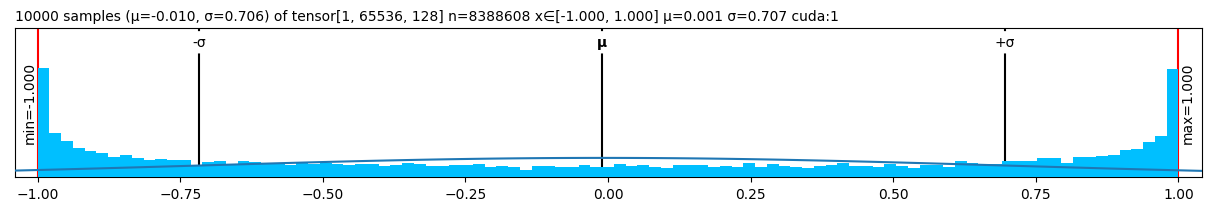

In [38]:
display(encoded_input.plt)

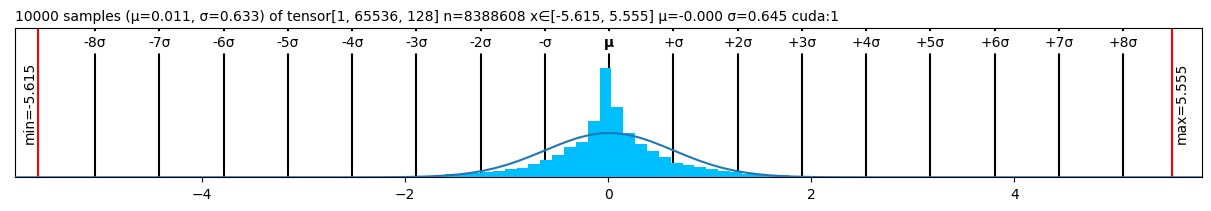

In [40]:
display((h1*10).plt)

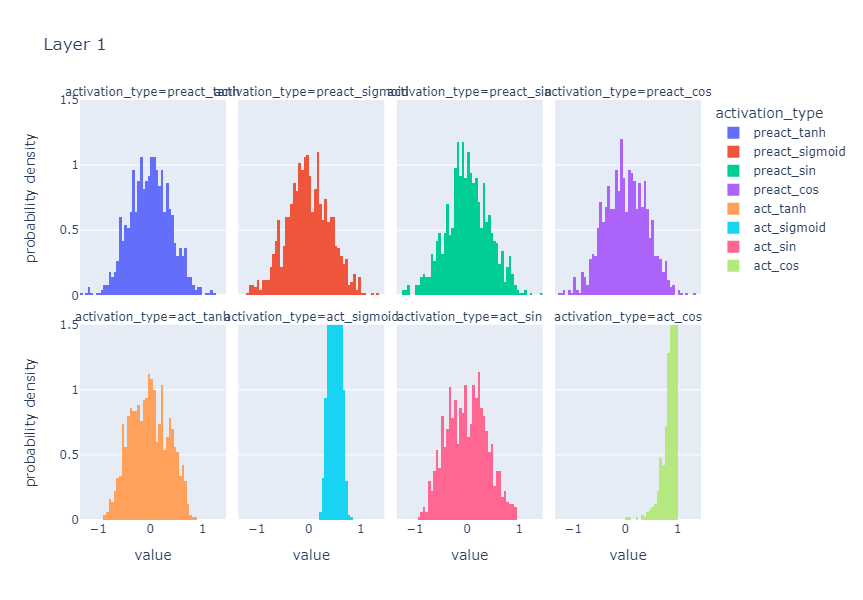

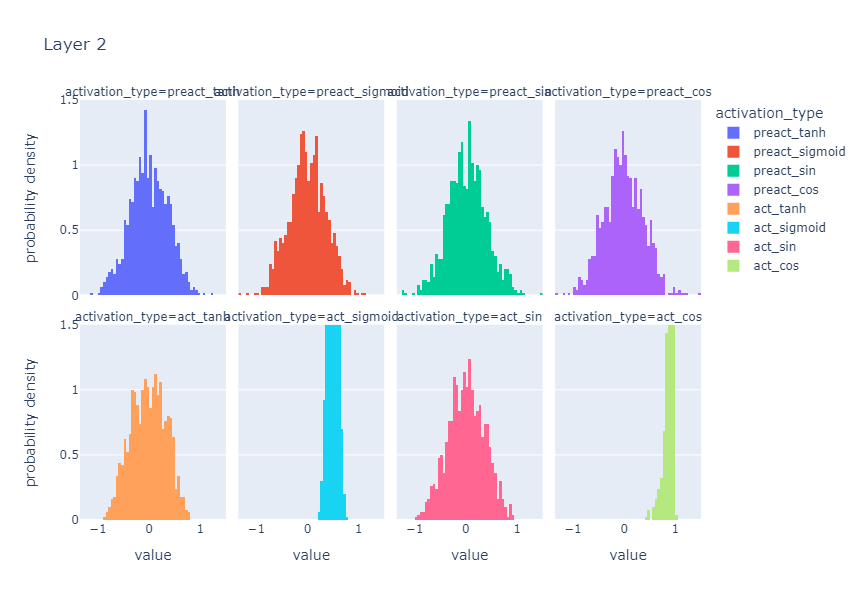

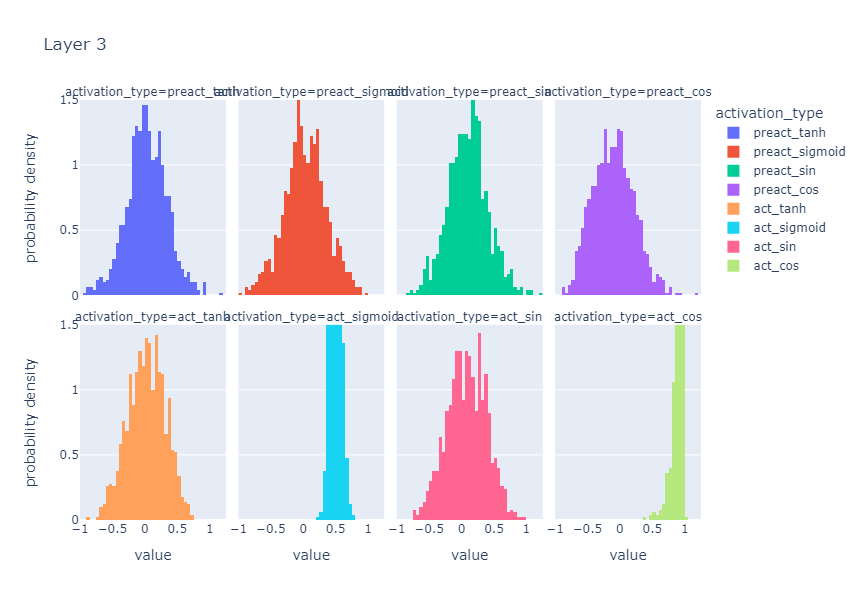

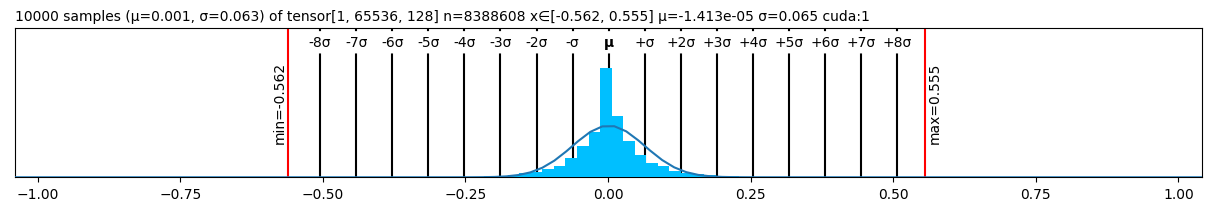

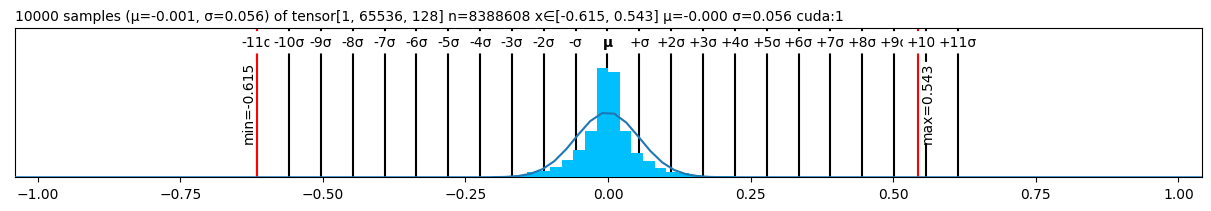

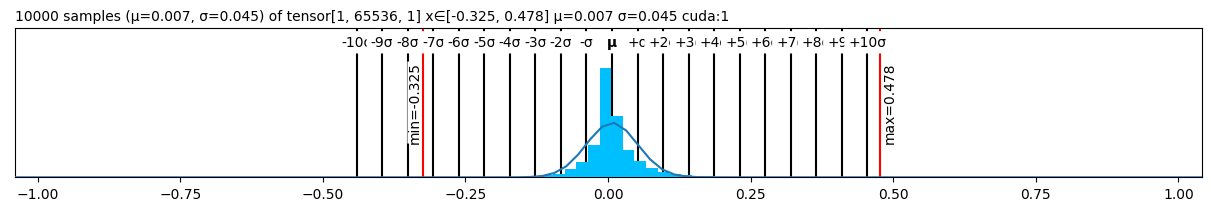

In [45]:
h1, layer1_acts = splitlayer_forward(encoded_input, W1, b1)
h2, layer2_acts = splitlayer_forward(h1*10, W2, b2)
h3, layer3_acts = splitlayer_forward(h2*10, W3, b3)
plot_acts(layer1_acts, 'Layer 1')
plot_acts(layer2_acts, 'Layer 2')
plot_acts(layer3_acts, 'Layer 3')


display(h1.plt)
display(h2.plt)
display(h3.plt)
# plot_acts(layer3_acts, 'Layer 2')

In [19]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [ ]:
total_steps = 1001
steps_til_summary = 100
seed = 0

# net = SimplePureSplitNet().init().to(device)
net = SimpleSplitNet().init().to(device)

seed_all(seed)
print(f'Set seed={seed}')

losses = []

optim = torch.optim.AdamW(lr=3e-4, params=net.parameters)



ud = []

for step in range(total_steps):

    # coords = model_input
    # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input

    model_output, interim_acts = net.raw_forward(model_input)

    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse


    if not step % steps_til_summary:
        print(f"Step {step}: psnr={psnr:0.6f} mse={loss:0.6f}")
    #         img_grad_tensor = gradient(model_output, coords)
    #         img_laplacian_tensor = laplace(model_output, coords)

        img = imagify_tensor(model_output)
    #         img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
    #         img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = tensor2pil(img)
        plt.imshow(colage)
        plt.show()
        
        if len(losses) > 10:
            plt.plot(losses)
            plt.show()


    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

In [ ]:
break

In [ ]:
from IPython.display import Markdown

In [ ]:
total_steps = 1001
steps_til_summary = 100
seed = 0

# net = SimplePureSplitNet().init().to(device)
net = SimpleSplitNet().init().to(device)

seed_all(seed)
print(f'Set seed={seed}')

losses = []

optim = torch.optim.AdamW(lr=3e-4, params=net.parameters)



ud = []

for step in range(total_steps):

    # coords = model_input
    # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input

    model_output, interim_acts = net.raw_forward(model_input)

    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse


#     if not step % steps_til_summary:
#         print(f"Step {step}: psnr={psnr:0.6f} mse={loss:0.6f}")
#     #         img_grad_tensor = gradient(model_output, coords)
#     #         img_laplacian_tensor = laplace(model_output, coords)

#         img = imagify_tensor(model_output)
#     #         img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
#     #         img_laplacian = imagify_tensor(img_laplacian_tensor)

#         colage = tensor2pil(img)
#         plt.imshow(colage)
#         plt.show()
        
#         if len(losses) > 10:
#             plt.plot(losses)
#             plt.show()

    
    # if step % 50 == 0:
    if step in [50, 100, 200, 225, 250]:
        display ( Markdown(f'# iter={step:03}') )

        # plot_acts(interim_acts[0], 'Layer 1')
        # plot_acts(interim_acts[1], 'Layer 2')
        plot_acts(interim_acts[2], 'Layer 2')

        for acts in interim_acts:
            a = acts[0]
            display(a.plt)
            
        print(f"Step {step}: psnr={psnr:0.6f} mse={loss:0.6f}")
    #         img_grad_tensor = gradient(model_output, coords)
    #         img_laplacian_tensor = laplace(model_output, coords)

        img = imagify_tensor(model_output)
    #         img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
    #         img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = tensor2pil(img)
        plt.imshow(colage)
        plt.show()
        
        if len(losses) > 10:
            plt.plot(losses)
            plt.show()


    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

In [ ]:
for p in net.parameters:
    print(p.shape)

In [ ]:
for p in net.parameters:
    print(p.grad.abs().max())

In [ ]:
plot_acts(interim_acts[0], 'Layer 1')

plot_acts(interim_acts[1], 'Layer 2')

plot_acts(interim_acts[2], 'Layer 2')

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(df, x="total_bill", y="tip", color="sex", facet_row="time", facet_col="day",
       category_orders={"day": ["Thur", "Fri", "Sat", "Sun"], "time": ["Lunch", "Dinner"]})
fig.show()